In [1]:
# 1. mounting google drive  
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer_Vision/CW' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', 'CW_Dataset_', 'input_files.zip', '4-HOG_SVM.ipynb', 'model_accuracies.jpeg', 'model.pth', '3-SIFT_MLP.ipynb', 'FacialExpressions_HOG_SVM_with_saving.ipynb', 'FacialExpressions_SIFT_MLP_with_saving.ipynb', '2-CNN_Video.ipynb', 'result_video.mp4', '1-CNN_Rev_B.ipynb']


In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [4]:
# importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
import torch 
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.optim as optim

# setting random seed for pytorch and numpy for reproducible results
torch.manual_seed(10)
np.random.seed(0)


In [5]:
train_imgs_folderpath = '/content/CW_Dataset/train/'
train_labels_folderpath = '/content/CW_Dataset/labels/list_label_train.txt'
test_imgs_folderpath = '/content/CW_Dataset/test/'
test_labels_folderpath = '/content/CW_Dataset/labels/list_label_test.txt'

In [6]:
# specifying the emotions related to the labels
label_to_emotion = { 1:'Surprise' , 2:'Fear' , 3:'Disgust' , 4:'Happiness' , 5:'Sadness', 6:'Anger', 7:'Neutral'  } # here the labels are before encoding . After encoding 1 maps to 0, 2 to 1 and so on

In [7]:
#Train images filename sorting
train_filesname_fromlabelsfile = []
train_labels = []

content = open(train_labels_folderpath).read().split('\n')

for entry in content:
  filename, label = entry.split()
  train_filesname_fromlabelsfile.append(filename)
  train_labels.append(int(label))


train_filenames = []

for filename in train_filesname_fromlabelsfile:
  name,ext = filename.split('.')
  updated_name = name + '_aligned' + '.' + ext
  train_filenames.append(updated_name)


#Test images filename sorting
test_filesname_fromlabelsfile = []
test_labels = []

content = open(test_labels_folderpath).read().split('\n')

for entry in content:
  filename, label = entry.split()
  test_filesname_fromlabelsfile.append(filename)
  test_labels.append(int(label))


test_filenames = []

for filename in test_filesname_fromlabelsfile:
  name,ext = filename.split('.')
  updated_name = name + '_aligned' + '.' + ext
  test_filenames.append(updated_name)

In [8]:
# printing statistics for training and testing set filenames and labels 
print("Total number of training image files: {}".format(len(train_filenames)))
print("Sample training image filename: {}".format(train_filenames[0]))
train_labels_unique , train_labels_unique_count = np.unique(train_labels, return_counts=True)
print("Count and unique labels values in the training set: Values:{} , Counts:{}".format(train_labels_unique, train_labels_unique_count))

print("")
print("Total number of testing image files: {}".format(len(test_filenames)))
print("Sample testing image filename: {}".format(test_filenames[0]))
test_labels_unique , test_labels_unique_count = np.unique(test_labels, return_counts=True)
print("Count and unique labels values in the testing set: Values:{} , Counts:{}".format(test_labels_unique, test_labels_unique_count))


Total number of training image files: 12271
Sample training image filename: train_00001_aligned.jpg
Count and unique labels values in the training set: Values:[1 2 3 4 5 6 7] , Counts:[1290  281  717 4772 1982  705 2524]

Total number of testing image files: 3068
Sample testing image filename: test_0001_aligned.jpg
Count and unique labels values in the testing set: Values:[1 2 3 4 5 6 7] , Counts:[ 329   74  160 1185  478  162  680]


In [9]:
# Converting labels to integer coded representation (label values starting from 0). labels are also converted from lists to numpy arrays
le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
test_labels_encoded  = le.transform(test_labels)

# printing sample label and it's one hot encoded representation 
print("Sample label {} , corresponding label/integer encoding: {}".format(train_labels[0], train_labels_encoded[0]))
print("Shape of train_labels_encoded: {} , Shape of test_labels_encoded: {}".format(train_labels_encoded.shape, test_labels_encoded.shape))

Sample label 5 , corresponding label/integer encoding: 4
Shape of train_labels_encoded: (12271,) , Shape of test_labels_encoded: (3068,)


In [10]:
train_imgs = [mpimg.imread(train_imgs_folderpath + filename) for filename in train_filenames]
train_imgs = np.array(train_imgs)

test_imgs = [mpimg.imread(test_imgs_folderpath + filename) for filename in test_filenames]
test_imgs = np.array(test_imgs)

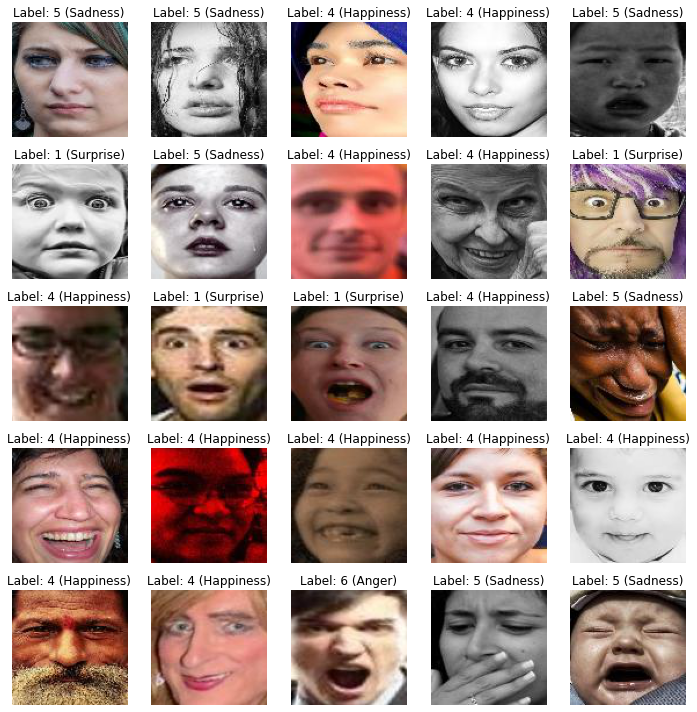

In [11]:
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()


idxs = np.random.choice( len(train_imgs), (num_rows*num_cols,) )
for i, idx in enumerate(idxs):
  ax[i].imshow(train_imgs[i])
  ax[i].set_title('Label: {} ({})'.format(train_labels[i], label_to_emotion[train_labels[i]]))
  ax[i].set_axis_off()
  fig.tight_layout()
plt.show()


In [12]:
# defining custom dataset class for drawing (x,y) samples where x is the preprocessed image and y is the corresponding label. 
class createDataset(Dataset) :
  def __init__(self, imgs_arr, labels_arr):
    super(createDataset, self).__init__()
    self.imgs_arr   = imgs_arr
    self.labels_arr = labels_arr 
    
    # transforms.ToTensor() transformation converts numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    self.transform = transforms.ToTensor() 

  def __getitem__(self, index):
    x = self.imgs_arr[index]
    x = self.transform(x)
    y = self.labels_arr[index]
    y = torch.tensor(y)
    return x,y

  def __len__(self):
    return len(self.labels_arr)


In [13]:
# creating train and test datasets
train_dataset = createDataset(train_imgs, train_labels_encoded)
test_dataset  = createDataset(test_imgs, test_labels_encoded)

In [14]:
train_batch_size = 64
test_batch_size  = 64

In [15]:
# creating train and test set dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

torch.Size([64, 3, 100, 100]) torch.Size([64])
tensor(0.) tensor(1.)


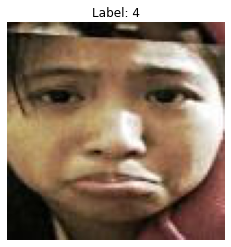

In [16]:
# visualizing a sample image from the dataset (also, for verifying correctness of the dataloader)
sample_imgs, sample_labels = next(iter(test_dataloader))
print(sample_imgs.shape, sample_labels.shape)
print(torch.min(sample_imgs), torch.max(sample_imgs))
sample_img = sample_imgs[0].permute(1,2,0) #100 x 100 x 3
sample_label = sample_labels[0]
plt.imshow(sample_img)
plt.title("Label: {}".format(sample_label))
plt.axis('off')
plt.show()

In [17]:
class cnn_model(nn.Module):
  def __init__(self, num_classes=7) :
    super(cnn_model, self).__init__()
    self.num_classes = num_classes
    self.base_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1), # (100 + (2)2*padding - 3(kernel_size)) // stride + 1  = 100 ; 100,100,3 -> 100,100,32
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1), # output shape - 100,100,32
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2), # output - 50,50,32 ; (100-2)//2 + 1

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1), # 50,50,32
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2), # 25,25,32

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1), # 25,25,64
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(2), # (25-2)//2 + 1 = 12
        nn.Dropout(0.25),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1), #12,12,64
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(2), #6,6,64
        nn.Dropout(0.25),

        )
    
    self.classifier_layer = nn.Sequential(
        nn.Linear(in_features= 2304, out_features= 256), # updated number of out_features # 6*6*64
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features= 256),  # updated number of num_features
        nn.Dropout(0.5),  
        nn.Linear( in_features= 256, out_features= self.num_classes)    # updated number of in_features
        )      
        
  def forward(self,x) :
    x = self.base_layer(x)
    x = x.reshape(x.size(0),-1)
    out = self.classifier_layer(x)
    return out


In [18]:
# setting up training parameters

# setting device to be gpu/cuda or cpu
device  = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Device used is {}".format(device))

# # set up model for training 
model = cnn_model()
model.train() 
model.to(device) # send model to device/GPU for training 

# defining loss to be CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Device used is cuda


In [22]:
def test_loss_acc(test_dataloader, model):
  model.eval()

  batch_losses = []
  batch_accuracies = []

  with torch.no_grad():
    for (x,y) in test_dataloader:
      num_samples = y.size(0)

      x = x.to(device)
      y = y.to(device)

      output = model(x)
      loss = criterion(output, y)
      batch_losses.append(loss.item())

      _,pred_labels = torch.max(output, dim=1)
      acc = (y == pred_labels).sum()/num_samples
      batch_accuracies.append(acc.item())

    test_loss = sum(batch_losses)/len(batch_losses)
    test_accuracy = sum(batch_accuracies)/len(batch_accuracies)

  return test_loss, test_accuracy



In [23]:
num_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for i in range(num_epochs):
  batch_losses =[]
  batch_accuracies = []
  
  for t, (x,y) in enumerate(train_dataloader):
    num_samples = y.size(0)

    x = x.to(device)
    y = y.to(device)

    output = model(x)
    loss = criterion(output, y)
    batch_losses.append(loss.item())

    _,pred_labels = torch.max(output, dim=1)
    acc = (y == pred_labels).sum()/num_samples
    batch_accuracies.append(acc.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 100 == 0:
      print('Epoch {}/{}, Iteration {}, loss={:.4f}, acc ={:.2f}'.format(i+1, num_epochs, t+1, loss.item(), acc.item()))

  train_losses.append(sum(batch_losses)/len(batch_losses))
  train_accuracies.append(sum(batch_accuracies)/len(batch_accuracies))

  test_loss, test_accuracy = test_loss_acc(test_dataloader, model)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print('After Epoch {}, train loss = {}, train acc = {}, test loss = {}, test acc = {}'.format(i+1, train_losses[-1], train_accuracies[-1], test_loss, test_accuracy))
  

Epoch 1/10, Iteration 1, loss=0.8346, acc =0.78
Epoch 1/10, Iteration 101, loss=1.0657, acc =0.69
After Epoch 1, train loss = 1.0065353993947308, train acc = 0.6594411429638664, test loss = 0.8704630707701048, test acc = 0.6857421882450581
Epoch 2/10, Iteration 1, loss=0.6879, acc =0.77
Epoch 2/10, Iteration 101, loss=0.5435, acc =0.77
After Epoch 2, train loss = 0.7174098693455259, train acc = 0.7453180405621728, test loss = 0.7727754690373937, test acc = 0.7266276056567827
Epoch 3/10, Iteration 1, loss=0.6604, acc =0.78
Epoch 3/10, Iteration 101, loss=0.9003, acc =0.72
After Epoch 3, train loss = 0.6530612471203009, train acc = 0.7642276842767993, test loss = 0.6830345873410503, test acc = 0.7498480913539728
Epoch 4/10, Iteration 1, loss=0.5322, acc =0.80
Epoch 4/10, Iteration 101, loss=0.4653, acc =0.80
After Epoch 4, train loss = 0.5288913029556473, train acc = 0.8145881813640395, test loss = 0.7166896648705006, test acc = 0.7536892369389534
Epoch 5/10, Iteration 1, loss=0.5549, ac

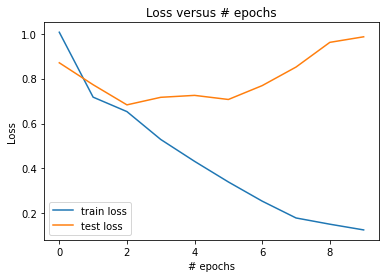

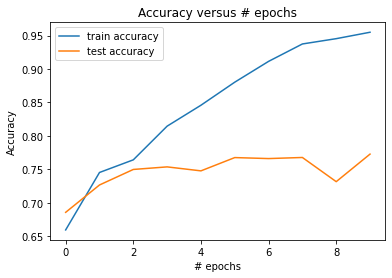

In [24]:
# plotting the train and test set losses and accuracies
epochs = np.arange(num_epochs)

plt.title("Loss versus # epochs")
plt.ylabel("Loss")
plt.xlabel("# epochs")
plt.plot(epochs, train_losses, label='train loss')
plt.plot(epochs, test_losses, label='test loss')
plt.legend()

plt.figure()
plt.title("Accuracy versus # epochs")
plt.ylabel("Accuracy")
plt.xlabel("# epochs")
plt.plot(epochs, train_accuracies, label='train accuracy')
plt.plot(epochs, test_accuracies, label='test accuracy')
plt.plot()
plt.legend()

plt.show()

In [26]:
# defining function to get the predicted labels from the trained model 
def get_pred_label(model, img):
  img = img.copy()
  img_tensor = torch.from_numpy(img)
  img_tensor = img_tensor/255.
  img_tensor = torch.unsqueeze(img_tensor, 0)
  img_tensor = img_tensor.permute(0,3,1,2)
  img_tensor = img_tensor.to(device)
  model.eval() # set model to evaluation mode 
  output = model(img_tensor)
  _, pred_label = torch.max(output, dim=1)
  return pred_label[0].item()

In [27]:
# getting model predictions on training set
num_samples = len(train_imgs)
preds_train = []
for i in range(num_samples) :
  pred = get_pred_label(model, train_imgs[i])
  preds_train.append(pred)

In [28]:
# getting model predictions on testing set
num_samples = len(test_imgs)
preds_test = []
for i in range(num_samples) :
  pred = get_pred_label(model, test_imgs[i])
  preds_test.append(pred)

In [29]:
# printing accuracy scores 
acc_train = accuracy_score(train_labels_encoded, preds_train)
acc_test  = accuracy_score(test_labels_encoded, preds_test)
print("Train accuracy: {}, Test accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.9704180588379105, Test accuracy: 0.7728161668839635


In [30]:
# printing confusion matrix for the test set
print("Confusion matrix ")
confusion_matrix(test_labels_encoded, preds_test)

Confusion matrix 


array([[ 245,    6,    4,   12,   17,    2,   43],
       [   9,   30,    0,    8,    6,   10,   11],
       [   7,    3,   46,   16,   19,   13,   56],
       [  15,    1,    2, 1068,   23,    6,   70],
       [  14,    1,   10,   44,  308,    7,   94],
       [   7,    3,   10,   15,   12,   98,   17],
       [  19,    0,   11,   20,   50,    4,  576]])

In [31]:
# printing classification report 
print("Classification report")
print(classification_report(test_labels_encoded , preds_test))

Classification report
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       329
           1       0.68      0.41      0.51        74
           2       0.55      0.29      0.38       160
           3       0.90      0.90      0.90      1185
           4       0.71      0.64      0.67       478
           5       0.70      0.60      0.65       162
           6       0.66      0.85      0.74       680

    accuracy                           0.77      3068
   macro avg       0.71      0.63      0.66      3068
weighted avg       0.77      0.77      0.77      3068



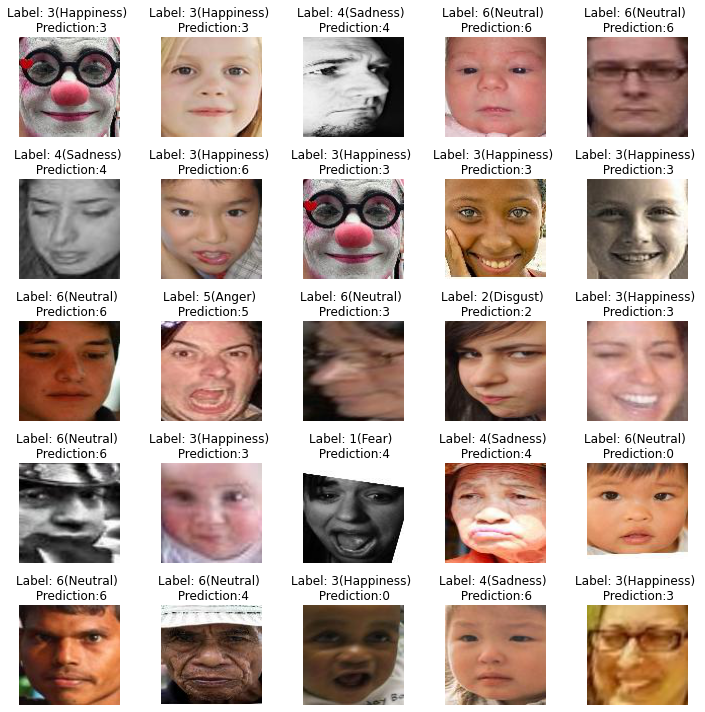

In [32]:
# visualizing the predictions 

num_rows = 5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

idxs = np.random.choice( len(test_imgs), (num_rows*num_cols,) )
for i, idx in enumerate(idxs):
  ax[i].imshow(test_imgs[idx])
  ax[i].set_title('Label: {}({}) \n Prediction:{}'.format(test_labels_encoded[idx], label_to_emotion[test_labels[idx]], preds_test[idx]))
  ax[i].set_axis_off()
fig.tight_layout()
plt.show()
